In [11]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0 # store the gradient/derivative with respect to L, to start we assume every value has no effect on the output (0)
        # store the children when math expressions are run on this value instance
        self._prev = set(_children) # ? set is probably just for efficiency
        self._op = _op # math operation stored that was run
        self.label = label

    def __repr__(self):
        return f'Value(data={self.data})'

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*') # pass in children (this is working towards allowing chaining operations and keeping track of an expression graph)
        return out

print(Value(2.0)) # just wraps a value that is passed in

a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
print(a+b)
print(a*b)

e = a*b; e.label='e'
d = e + c; d.label='d'
print(d)
print(f'children: {d._prev}')
print(f'operation: {d._op}')

f = Value(-2.0, label='f')
# output of graph:
L = d * f; L.label='L'
print(L)

Value(data=2.0)
Value(data=-1.0)
Value(data=-6.0)
Value(data=4.0)
children: {Value(data=-6.0), Value(data=10.0)}
operation: +
Value(data=-8.0)


In [12]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

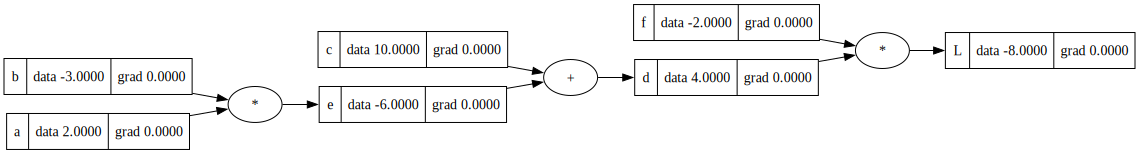

In [13]:
##### FORWARD PASS

draw_dot(L) # The output of the forward-pass is -8 here

In [14]:
###########################################
#
#              BACK PROPAGATION
#
###########################################

# Start at the end (L) and reverse calculate the gradient at all of the intermediate values
  # Compute the derivate of the value of each node with respect to L
  # Ex: the derivative of L with respect to L is just 1, get derivate of L with respect to f, with respect to d, etc..
# We're interested in the derivative of this loss function L, with respect to the weights of the neural network
  # the goal is to know how weights are impacting the loss function 
  #   #(interested in the derivative of the output with respect to some of its leaf nodes/weights)
      # other leaf nodes will be the data itself that we won't want to use because the data is fixed and not parameters/variable


# Set the base gradient which is 1 for the output of L (whatever we increase L by, the output increases the same amount)
L.grad = 1

# get derivatives of L with respect to d and f (they are f and d respectively)
f.grad = 4.0 # value of d
d.grad = -2.0 # value of f

#########################
#
#      CHAIN RULE
#
#########################

### Now to find how c impacts L, you need to know how c impacts d and how d impacts L (which we know) and put that information together to get an idea of how c affects L

# Use the CHAIN RULE from Calculus: dz/dx = dz/dy * dy/dz
  # z depends on y, and y depends on x (one step from z via y) - similar to how c and e are one step from L via d in our expression graph
  # The product of the two rates of change (z to y and y to x) will give the rate of change of z with respect to x
  # example: if a car travels twice as fast as a bicycle, and a bicycle 4 times as fast as a man, then a car travels 8 times (2x4) fast as a man

# first find the derivative of d with respect to c:
  # d = c + e
  # (c+h + e) - (c + e) / h -- rise over run calculation
  # c + h + e - c + e -> c/-c and e/-e cancels out which leaves h -> h/h = 1

# "Local derivatives" - c and e only created d, but know nothing about L
d_respect_to_c = 1.0 # how change in c affects d (not L)
d_respect_to_e = 1.0 # how change in e affects d (not L)

# dL / dc = (dL / dd) * (dd / dc) -> grad of L with respect to d multiplied grad of d with respect to c
c.grad = d.grad * d_respect_to_c # -2 via the chain rule - c.grad val stored is how c affects L
e.grad = d.grad * d_respect_to_e

################################################################################################################################################################################################
#### NOTE: plus/addition nodes just make the gradient 1.0 because raising them by a small amount results in raising the output by the same amount, so the local derivative for these nodes is always 1
################################################################################################################################################################################################


# Now get the derivative of L with respect to a and b - again use the chain rule
# dL / da = (de / da) * (dL / de) -> change of L with respect to a = local derivative (change of e with respect to a) multiplied by the already computed change of L with respect to e
e_respect_to_a = -3.0 # value of b is how much a change in a affects e
a.grad = e.grad * e_respect_to_a # -2 * -3

e_respect_to_b = 2.0 # value of a is how much change in b affects e
b.grad = e.grad * e_respect_to_b # -2 * 2

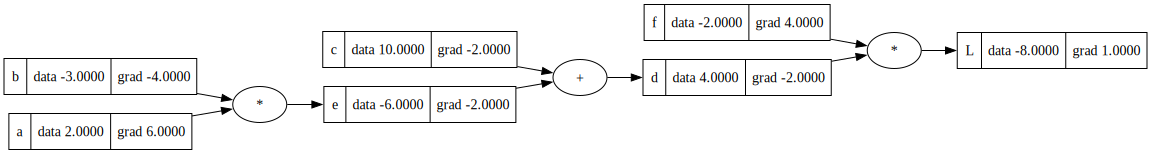

In [ ]:
# EXPRESSION GRAPH AFTER BACK PROPAGATION

# gradients are filled in that tell us how much each node affects the output L
  # all were calculated by applying the chain rule by recursively multiplying by the local derivatives backwards through the expression graph

draw_dot(L)

In [16]:
### Manual rough way of checking/confirming the gradient - estimation via small step size change
  # after calculating derivatives with respect to L above to fill in expression graph, can verify them here

def estimate_grad():
    h = 0.001 # small change

    # Unaffected function output
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f')
    L = d * f; L.label='L'
    L1 = L.data # original function output
    
    # add h to check derivative of L with respect to a,b,c,d,etc...
    a = Value(2.0, label='a')
    b = Value(-3.0, label='b')
    b.data += h
    c = Value(10.0, label='c')
    e = a*b; e.label='e'
    d = e + c; d.label='d'
    f = Value(-2.0, label='f') 
    L = d * f; L.label='L'
    L2 = L.data # Affected function output after a change in parameter

    print((L2 - L1) / h) # rise over run

estimate_grad()

-3.9999999999995595


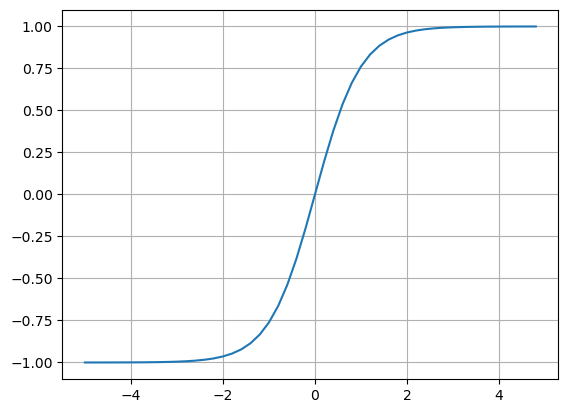

In [1]:
### Squashing Function (tanh)
import numpy as np
import matplotlib.pyplot as plt
# Outputs get squashed on the y-axis
# As you go more positive from 0 on the input the output rapidly approaches 1 and plateaus there
# As you go more negative from 0 the output squashes and plateaus to -1

### tanh ###
x = np.arange(-5,5,0.2)
y = np.tanh(x)

plt.plot(x,y)
plt.grid()
plt.show()
